Rad229_EPI_T2star_Blurring_Demo demonstrates T2* blurring in echo planar imaging (EPI).

QUESTIONS
1. When using a top-down EPI trajectory the apparent spatial resolution of tissues with a long T2* is different when compared to short T2* tissues. How is it different? Why?

2. What changes about the spatial resolution and contrast with a center-out EPI trajectory?

3. What happens to image contrast and resolution if the echo spacing increases? Decreases?

4. [Advanced] What limits echo spacing from being very, very short? If the dwell time for the readout is as short as possible, then what is the approximate ratio of phase encode to frequency encode bandwidth?

5. [Advanced] Code an example of spin-echo EPI and compare the contrast and resolution differences.

6. [Advanced] Code an example of T2*-blurring and chemical shift artifacts in EPI. 

DBE@STANFORD.EDU (May 2020) Matlab version for Rad229

DBE@STANFORD.EDU (April 2025) Python version for Rad229

In [ ]:
# -- We use the functions in mrsigpy, as well as standard numpy and matpltlib
#! git clone https://github.com/mribri999/MRSignalsSeqs.git &> /dev/null # Clones the RAD229 repo
#import sys, os
#python_code_path = '/content/MRSignalsSeqs/Python/'
#sys.path.append(python_code_path) # To load the mrsigpy functions
#os.chdir(python_code_path) # Change directory to Python folder
 
import numpy as np
import matplotlib.pyplot as plt
from Rad229_MRI_Resolution_Phantom import Rad229_MRI_Resolution_Phantom

# Acquisition parameters
acq = {}
acq['Nx'] = 128           # Matrix size (Ny x Nx) (rows x columns)
acq['Ny'] = 129           # Matrix size (Ny x Nx)
acq['Nt'] = acq['Ny']     # One time step per echo
acq['ESP'] = 1.0e-3       # EPI echo spacing [s]

# Object parameters
obj = {}
obj['M0'] = 1.0 # Bulk magnetization
obj['T2star'] = [10e-3, 25e-3, 100e-3, 250e-3, 500e-3]  # Range of T2-star values [s]

# Time vector
t = acq['ESP'] * np.arange(1, acq['Nt'] + 1)

# Transverse magnetization (Mxy) decay matrix
Mxy = np.zeros((len(t), len(obj['T2star'])))
for n, T2 in enumerate(obj['T2star']):
    Mxy[:, n] = obj['M0'] * np.exp(-t / T2)

The magnetization decays according to:
$$ M_{xy} = M_0 e^{-\frac{t}{T_2}}$$

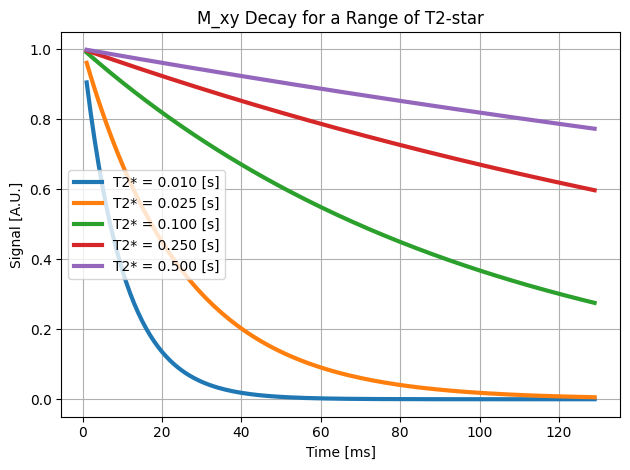

In [2]:
# Plot the transverse magnetization (Mxy) decay
plt.figure()
for n in range(len(obj['T2star'])):
    plt.plot(1000*t, Mxy[:, n], linewidth=3, label=f"T2* = {obj['T2star'][n]:.3f} [s]")

plt.title('M_xy Decay for a Range of T2-star')
plt.xlabel('Time [ms]')
plt.ylabel('Signal [A.U.]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

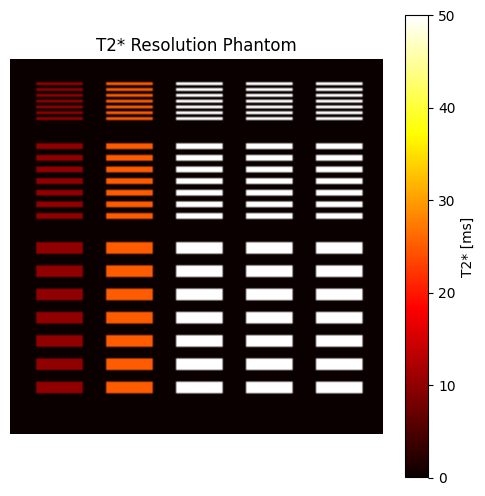

In [3]:
# Generate resolution phantom with a range of T2*
P = Rad229_MRI_Resolution_Phantom(acq, obj)
P = P + 1e-12 # Avoid some divide-by-zero problems

plt.figure(figsize=(6, 6))
plt.imshow(1000*P, cmap='hot', origin='upper', aspect='equal', vmin=1000*np.min(P), vmax=1000*np.max(P) / 10)
plt.colorbar(label='T2* [ms]')
plt.axis('off')  # or use: plt.axis('equal'); plt.tight_layout()
plt.title('T2* Resolution Phantom')
plt.show()

In [4]:
# Create a 2D+time array by repeating P along the time dimension
P_t = np.repeat(P[:, :, np.newaxis], acq['Nt'], axis=2)
P_t = P_t.astype(np.complex128)

# Apply T2*-decay across the time dimension
for n in range(acq['Nt']):
    t_decay = n * acq['ESP']
    P_t[:, :, n] = obj['M0'] * np.exp(-t_decay / P)

# Add complex Gaussian noise (real + imaginary)
noise = (np.random.randn(*P_t.shape) + 1j * np.random.randn(*P_t.shape)) / 2500
P_t += noise

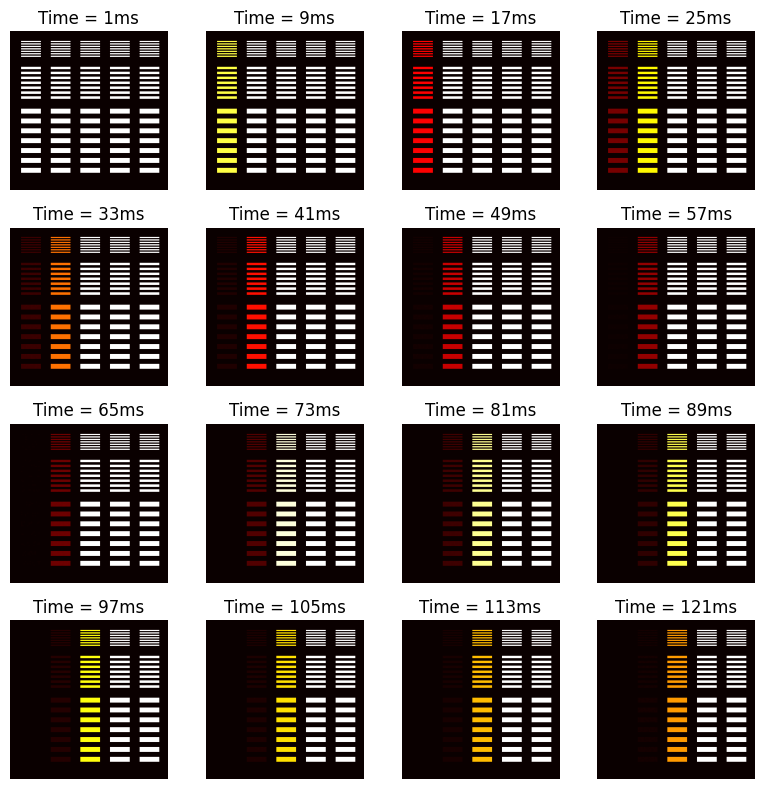

In [5]:
# Show some images from the data
ind = range(1, P_t.shape[2], 8)

# Plot in a grid (auto-adjusting rows/cols)
n = len(ind)
cols = 4
rows = int(np.ceil(n / cols))

plt.figure(figsize=(cols * 2, rows * 2))

for i, idx in enumerate(ind):
    time = int(1000 * idx * acq['ESP'])
    plt.subplot(rows, cols, i + 1)
    plt.imshow(np.abs(P_t[:, :, idx]), cmap='hot', vmin=np.min(P), vmax=np.max(P))
    plt.title(f'Time = {time}ms')
    plt.axis('off')

plt.tight_layout()
plt.show()

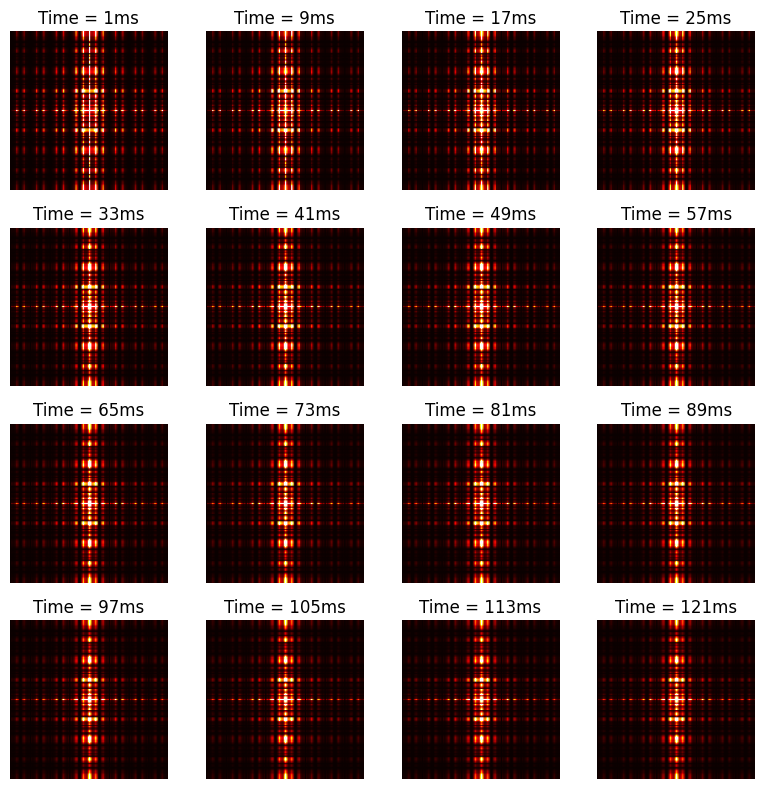

In [ ]:
# Compute the k-space

# Preallocate k-space array with same shape, and complex type
kspc = np.zeros_like(P_t, dtype=np.complex128)

# Fill each k-space slice
for n in range(acq['Nt']):
    kspc[:, :, n] = np.fft.fftshift(np.fft.fft2(P_t[:, :, n]))

kspc_min = np.min(np.abs(kspc))
kspc_max = np.max(np.abs(kspc))

plt.figure(figsize=(cols * 2, rows * 2))

for i, idx in enumerate(ind):
    time = int(1000 * idx * acq['ESP'])
    plt.subplot(rows, cols, i + 1)
    plt.imshow(np.abs(kspc[:, :, idx]), cmap='hot', vmin=kspc_min, vmax=kspc_max/100)
    plt.title(f'Time = {time}ms')
    plt.axis('off')

plt.tight_layout()
plt.show()

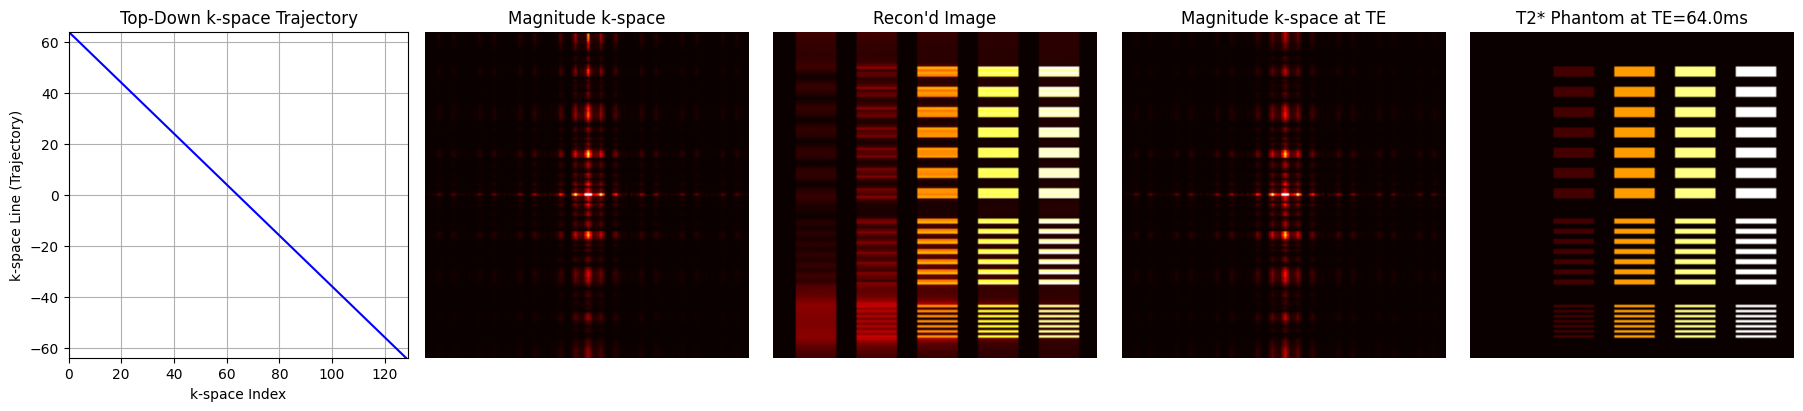

In [7]:
# Simulate the TOP-DOWN EPI trajectory
kspc_epi_td = np.zeros((acq['Ny'], acq['Nx']), dtype=np.complex128)

# EPI-style sampling: one ky-line per time point
kspc_ind = np.arange(acq['Nt'])
kspc_traj = np.arange(acq['Nt']-1, -1, -1)
ind_TE = np.argmin(np.abs(kspc_traj - int(acq['Ny']/2)))

for n in range(acq['Ny']):
    kspc_epi_td[kspc_traj[n], :] = kspc[kspc_traj[n], :, n]  # Grab line kspc_traj[n] from timepoint n

# Reconstruct image via inverse FFT
IM_epi_td = np.fft.ifft2(np.fft.ifftshift(kspc_epi_td))
TE_ms = ind_TE * acq['ESP'] * 1000

# Figure of the results
fig, axs = plt.subplots(1, 5, figsize=(18, 4), constrained_layout=True)

kspc_min = np.min(np.abs(kspc_epi_td))
kspc_max = np.max(np.abs(kspc_epi_td))
ispc_min = np.min(np.abs(IM_epi_td))
ispc_max = np.max(np.abs(IM_epi_td))

# Subplot 1: k-space trajectory
axs[0].plot(kspc_ind, kspc_traj - int(acq['Ny']/2), linestyle='-', color='blue')
axs[0].set_title('Top-Down k-space Trajectory')
axs[0].set_xlabel('k-space Index')
axs[0].set_ylabel('k-space Line (Trajectory)')
axs[0].set_xlim(0, acq['Ny'])
axs[0].set_ylim(- int(acq['Ny']/2), + int(acq['Ny']/2))
axs[0].grid(True)

# Subplot 2: Magnitude k-space
axs[1].imshow(np.abs(kspc_epi_td), cmap='hot', origin='lower', aspect='equal', vmin=kspc_min, vmax=kspc_max / 2)
axs[1].set_title('Magnitude k-space')
axs[1].axis('off')
axs[1].set_aspect('equal')

# Subplot 3: Reconstructed Image
axs[2].imshow(np.abs(IM_epi_td), cmap='hot', origin='lower', aspect='equal')
axs[2].set_title("Recon'd Image")
axs[2].axis('off')
axs[2].set_aspect('equal')

# Subplot 2: Original magnitude k-space at the TE
axs[3].imshow(np.abs(kspc[:, :, ind_TE]), cmap='hot', origin='lower', aspect='equal', vmin=kspc_min, vmax=kspc_max / 2)
axs[3].set_title('Magnitude k-space at TE')
axs[3].axis('off')
axs[3].set_aspect('equal')

# Subplot 4: Original Object at the TE
P_tmin = 0 #1000*np.min(np.abs(P_t))
P_tmax = 1000*np.max(np.abs(P_t[:, :, ind_TE])) / 1
axs[4].imshow(1000 * np.abs(P_t[:, :, ind_TE]), cmap='hot', origin='lower', aspect='equal', vmin=P_tmin, vmax=P_tmax)
axs[4].set_title(f'T2* Phantom at TE={TE_ms}ms')
axs[4].axis('off')
axs[4].set_aspect('equal')

How would you describe the image contrast and resolution for this k-space trajectory?

0.620584445259623
1.6019077623964904
0.00040205702718374705
1001.5825377380776


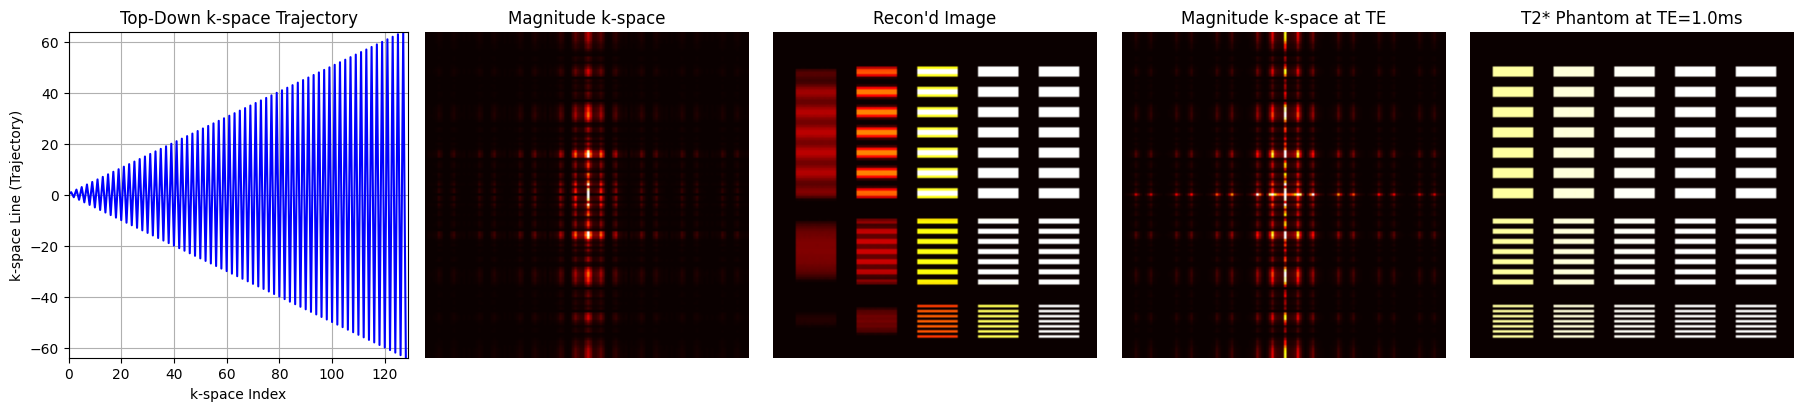

In [ ]:
# Simulate the CENTER-OUT EPI trajectory (a little more book keeping)
nk_up = int(acq['Ny']/2) + 1  # Number of k-points going up
nk_dn = int(acq['Ny']/2) + 0  # Number of k-points going down

k_up = list(range(nk_up, acq['Ny']))  # List of k-points going up
k_dn = list(range(nk_dn, -1, -1))  # List of k-points going down

# Center-out EPI sampling
kspc_traj = np.zeros(acq['Ny'], dtype=int)
kspc_traj[::2] = k_dn
kspc_traj[1::2] = k_up
ind_TE = np.argmin(np.abs(kspc_traj - int(acq['Ny']/2))) + 1
TE_ms = ind_TE * acq['ESP'] * 1000

kspc_epi_co = np.zeros((acq['Ny'], acq['Nx']), dtype=np.complex128)
for n in range(acq['Ny']):
    kspc_epi_co[kspc_traj[n], :] = kspc[kspc_traj[n], :, n]  # Grab line kspc_traj[n] from timepoint n

# Reconstruct image via inverse FFT
IM_epi_co = np.fft.ifft2(np.fft.ifftshift(kspc_epi_co))

# Figure of the results
fig, axs = plt.subplots(1, 5, figsize=(18, 4), constrained_layout=True)

kspc_min = np.min(np.abs(kspc_epi_co))
kspc_max = np.max(np.abs(kspc_epi_co))
ispc_min = np.min(np.abs(IM_epi_co))
ispc_max = np.max(np.abs(IM_epi_co))

# Subplot 1: k-space trajectory
axs[0].plot(kspc_ind, kspc_traj - int(acq['Ny']/2), linestyle='-', color='blue')
axs[0].set_title('Center-Out k-space Trajectory')
axs[0].set_xlabel('k-space Index')
axs[0].set_ylabel('k-space Line (Trajectory)')
axs[0].set_xlim(0, acq['Ny'])
axs[0].set_ylim(- int(acq['Ny']/2), + int(acq['Ny']/2))
axs[0].grid(True)

# Subplot 2: Magnitude k-space
axs[1].imshow(np.abs(kspc_epi_co), cmap='hot', origin='lower', aspect='equal', vmin=kspc_min, vmax=kspc_max / 25)
axs[1].set_title('Magnitude k-space')
axs[1].axis('off')
axs[1].set_aspect('equal')

# Subplot 3: Reconstructed Image
axs[2].imshow(np.abs(IM_epi_co), cmap='hot', origin='lower', aspect='equal', vmin=1.0, vmax=1.5)
axs[2].set_title("Recon'd Image")
axs[2].axis('off')
axs[2].set_aspect('equal')

# Subplot 5: Original magnitude k-space at the TE
axs[3].imshow(np.abs(kspc[:, :, ind_TE]), cmap='hot', origin='lower', aspect='equal', vmin=kspc_min, vmax=kspc_max / 25)
axs[3].set_title('Magnitude k-space at TE')
axs[3].axis('off')
axs[3].set_aspect('equal')

# Subplot 5: Original Object at the TE
P_tmin = 1000*np.min(np.abs(P_t))
P_tmax = 1000*np.max(np.abs(P_t))

P_tmin = 0 #1000*np.min(np.abs(P_t))
P_tmax = 1000*np.max(np.abs(P_t[:, :, ind_TE]))
axs[4].imshow(1000 * np.abs(P_t[:, :, ind_TE]), cmap='hot', origin='lower', aspect='equal') #, vmin=P_tmin, vmax=P_tmax)
axs[4].set_title(f'T2* Phantom at TE={TE_ms}ms')
axs[4].axis('off')
axs[4].set_aspect('equal')